https://www.kaggle.com/shravankumar9892/image-colorization

The dataset

# Preprocessing
### to preprocess dataset to be used by training

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/Dataset/kaggle dataset/image_colorise'

/content/gdrive/MyDrive/Dataset/kaggle dataset/image_colorise


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [ ]:
l=np.load('/content/gdrive/MyDrive/Dataset/kaggle dataset/image_colorise/l/gray_scale.npy')
l=l[:,:,:,np.newaxis]
print("shape of l",l.shape)
ab1=np.load('/content/gdrive/MyDrive/Dataset/kaggle dataset/image_colorise/ab/ab/ab1.npy')
print("shape of ab1",ab1.shape)
ab2=np.load('/content/gdrive/MyDrive/Dataset/kaggle dataset/image_colorise/ab/ab/ab2.npy')
ab1=np.concatenate((ab1,ab2),axis=0)
print("shape of ab",ab1.shape)
ab1=np.concatenate((l[:20000],ab1),axis=3)
print("shape of lab1",ab1.shape)
lab=np.zeros((20000, 128, 128,3),dtype=np.uint8)
gray=np.zeros((20000, 128, 128,1),dtype=np.uint8)
for i in range(20000):
  lab[i,:,:,:]=cv2.cvtColor(cv2.resize(cv2.cvtColor(ab1[i],cv2.COLOR_LAB2BGR),(128,128)),cv2.COLOR_BGR2LAB)
  gray[i,:,:,0]=cv2.cvtColor(cv2.cvtColor(lab[i],cv2.COLOR_LAB2RGB),cv2.COLOR_RGB2GRAY)


np.save("l1",lab[:,:,:,0])
np.save("a1",lab[:,:,:,1])
np.save("b1",lab[:,:,:,2])
np.save("gray1",gray)

shape of l (25000, 224, 224, 1)
shape of ab1 (10000, 224, 224, 2)
shape of ab (20000, 224, 224, 2)
shape of lab1 (20000, 224, 224, 3)


## Preprocessing has been completed
### now restart the kernal to proceed

# Training

note- don't re-run any cells twice especially training or else it might exceed the 12 gb ram, since for some reason keras grabage collection is bit broken

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importing libraries

In [ ]:
import sys, os
from keras.models import Sequential
from keras.layers import Activation, Input, Add, Concatenate, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D,Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
%cd '/content/gdrive/MyDrive/Dataset/kaggle dataset/image_colorise'

/content/gdrive/MyDrive/Dataset/kaggle dataset/image_colorise


## Explaination of model
Instead of using one shot deep learing which don't perform so well on less training data and also takes huge no. of parameters, we will seperately train 3 models for L, A and B space which will take lot less no of parameters and will be efficient 


## model for l

### Importing Data

In [ ]:
X_train=(np.load('gray1.npy')[:15000].astype('float64'))/255
Y_train=(np.load('l1.npy')[:15000].astype('float64'))/255

### model explained
I am using autoencoder structure with 2 layers for this, since its simle task.

There is one conv layer and one conv transpose layer. 

Then I have made modeification to generic model by concatinating input layer with the last layer (similar to skip connection) and then used 1*1 filter to get linear combination of those.

Model: "HappyModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 126, 126, 8)  80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_1 (Conv2DTrans (None, 128, 128, 1)  73          conv2d_2[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 128, 2)  0           conv2d_transpose_1[0][0]         
                                                                 input_2[0][0]           

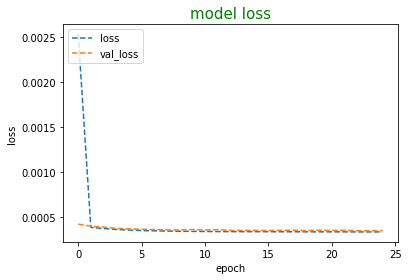

In [ ]:
fsize=3
def happyModel():
  X_input = Input(X_train.shape[1:])
  X1 = Conv2D(8, kernel_size=(3, 3), activation='relu')(X_input)
  Xf= Concatenate()([Conv2DTranspose(1, (3, 3), activation='sigmoid')(X1),X_input])
  Xf=Conv2D(1, (1, 1))(Xf)
  #Xf=Conv2D(1, (1, 1), activation='sigmoid')(X_input)
  model = Model(inputs = X_input, outputs = Xf, name='HappyModel')
  return model

model=happyModel()
model.summary()
model.compile(optimizer = "rmsprop", loss = 'mse' )
history =model.fit(X_train, Y_train,
          batch_size=32,
          epochs=25,
          verbose=1,
          validation_split=0.1,
          shuffle=True)
plt.plot(history.history['loss'], '--', label='loss')
plt.plot(history.history['val_loss'], '--',label='val_loss')
plt.title('model loss',fontsize=15, color='green')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
 
 
plt.show()

### saving model

In [ ]:
model.save('lbest.h5')

## model for a

In [ ]:
X_train=(np.load('gray1.npy')[:15000].astype('float64'))/255
Y_train=(np.load('a1.npy')[:15000].astype('float64'))/255

### model explained
Model for A space is similar to L but with more layers. I have used encoder and decoder which are symmetic and have skip concatination connection between symmetric layers. (first hidden layer concatinated to last hidden, 2nd to secondlast, and so on)  

I haven't used input layer because it was giving poorer resultes than without it.

Also the training graph might no look good, its because lots of progress happened in 1st epoch. At starting of firt epoc, loss was arround  0.8 

Model: "HappyModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 126, 126, 4)  40          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 124, 124, 8)  296         conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 122, 122, 16) 1168        conv2d_3[0][0]                   
_________________________________________________________________________________________

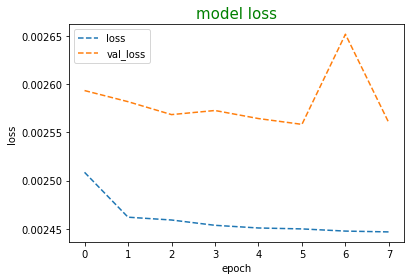

In [ ]:
fsize=3
def happyModel():
  X_input = Input(X_train.shape[1:])
  X1 = Conv2D(4, kernel_size=(3, 3), activation='relu')(X_input)
  X2=Conv2D(8, (3, 3), activation='relu')(X1)
  X3=Conv2D(16, (3, 3), activation='relu')(X2)
  X4=Conv2D(32, (3, 3), activation='tanh')(X3)
  Xf=Conv2D(64, (3, 3), activation='tanh')(X4)
  Xf=Concatenate()([Conv2DTranspose(32, (3, 3), activation='relu')(Xf),X4])
  Xf=Concatenate()([Conv2DTranspose(16, (3, 3), activation='relu')(Xf),X3])
  Xf=Concatenate()([Conv2DTranspose(8, (3, 3), activation='relu')(Xf),X2])
  Xf=Concatenate()([Conv2DTranspose(4, (3, 3), activation='relu')(Xf),X1])
  Xf=Conv2DTranspose(1, (3, 3), activation='sigmoid')(Xf)
  #X3=Conv2DTranspose(1, (3, 3), activation='sigmoid')(X3)
  model = Model(inputs = X_input, outputs = Xf, name='HappyModel')
  return model

model=happyModel()
model.summary()
model.compile(optimizer = "rmsprop", loss = 'mse' )
history =model.fit(X_train, Y_train,
          batch_size=32,
          epochs=8,
          verbose=1,
          validation_split=0.1,
          shuffle=True)
plt.plot(history.history['loss'], '--', label='loss')
plt.plot(history.history['val_loss'], '--',label='val_loss')
plt.title('model loss',fontsize=15, color='green')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
 
 
plt.show()

In [ ]:
model.save('abest.h5')

## model for b

In [ ]:
X_train=(np.load('gray1.npy')[:15000].astype('float64'))/255
Y_train=(np.load('b1.npy')[:15000].astype('float64'))/255

This is same as A but just with linear combination layer

Model: "HappyModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 126, 126, 4)  40          input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 126, 126, 4)  0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 124, 124, 8)  296         leaky_re_lu_10[0][0]             
_________________________________________________________________________________________

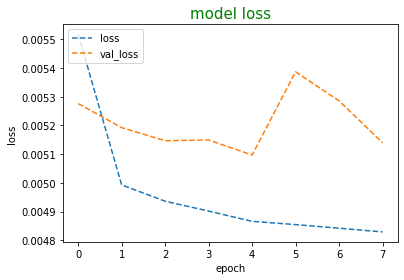

In [ ]:
fsize=3
def happyModel():
  X_input = Input(X_train.shape[1:])
  
  X1 = Conv2D(4, kernel_size=(fsize, fsize))(X_input)
  X1=LeakyReLU()(X1)
  
  X2=Conv2D(8, (fsize, fsize))(X1)
  X2=LeakyReLU()(X2)
  
  X3=Conv2D(16, (fsize, fsize))(X2)
  X3=LeakyReLU()(X3)
  
  X4=Conv2D(32, (fsize, fsize))(X3)
  X4=LeakyReLU()(X4)
  
  Xf=Conv2D(64, (fsize, fsize))(X4)
  Xf=LeakyReLU()(Xf)
  
  Xf=Concatenate()([Conv2DTranspose(32, (fsize, fsize))(Xf),X4])
  Xf=LeakyReLU()(Xf)

  Xf=Concatenate()([Conv2DTranspose(16, (fsize, fsize))(Xf),X3])
  Xf=LeakyReLU()(Xf)
  
  Xf=Concatenate()([Conv2DTranspose(8, (fsize, fsize))(Xf),X2])
  Xf=LeakyReLU()(Xf)
  
  Xf=Concatenate()([Conv2DTranspose(4, (fsize, fsize))(Xf),X1])
  Xf=LeakyReLU()(Xf)
  
  Xf=Concatenate()([Conv2DTranspose(1, (fsize, fsize))(Xf), X_input])
  Xf=LeakyReLU()(Xf)
  
  Xf=Conv2D(1, (1, 1), activation='sigmoid')(Xf)
  #Xf=Conv2DTranspose(1, (3, 3), activation='tanh')(Xf)
  #X3=Conv2DTranspose(1, (3, 3), activation='sigmoid')(X3)
  model = Model(inputs = X_input, outputs = Xf, name='HappyModel')
  return model

model=happyModel()
model.summary()
model.compile(optimizer = "rmsprop", loss = 'mse' )
history =model.fit(X_train, Y_train,
          batch_size=32,
          epochs=8,
          verbose=1,
          validation_split=0.1,
          shuffle=True)
plt.plot(history.history['loss'], '--', label='loss')
plt.plot(history.history['val_loss'], '--',label='val_loss')
plt.title('model loss',fontsize=15, color='green')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
 
 
plt.show()

In [ ]:
model.save('bbest.h5')

# testing


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys, os
from keras.models import Sequential
from keras.layers import Activation, Input, Add, Concatenate, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D,Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
%cd '/content/gdrive/MyDrive/Dataset/kaggle dataset/image_colorise'

/content/gdrive/MyDrive/Dataset/kaggle dataset/image_colorise


In [5]:
inp_shape=(128,128,1)
def LModel():
  X_input = Input(inp_shape)
  X1 = Conv2D(8, kernel_size=(3, 3), activation='relu')(X_input)
  Xf= Concatenate()([Conv2DTranspose(1, (3, 3), activation='sigmoid')(X1),X_input])
  Xf=Conv2D(1, (1, 1))(Xf)
  model = Model(inputs = X_input, outputs = Xf, name='HappyModel')
  return model
Lmodel=LModel()
Lmodel.summary()
Lmodel.compile(optimizer = "rmsprop", loss = 'mse' )
Lmodel.load_weights("lbest.h5")

def AModel():
  X_input = Input(inp_shape)
  X1 = Conv2D(4, kernel_size=(3, 3), activation='relu')(X_input)
  X2=Conv2D(8, (3, 3), activation='relu')(X1)
  X3=Conv2D(16, (3, 3), activation='relu')(X2)
  X4=Conv2D(32, (3, 3), activation='tanh')(X3)
  Xf=Conv2D(64, (3, 3), activation='tanh')(X4)
  Xf=Concatenate()([Conv2DTranspose(32, (3, 3), activation='relu')(Xf),X4])
  Xf=Concatenate()([Conv2DTranspose(16, (3, 3), activation='relu')(Xf),X3])
  Xf=Concatenate()([Conv2DTranspose(8, (3, 3), activation='relu')(Xf),X2])
  Xf=Concatenate()([Conv2DTranspose(4, (3, 3), activation='relu')(Xf),X1])
  Xf=Conv2DTranspose(1, (3, 3), activation='sigmoid')(Xf)
  #X3=Conv2DTranspose(1, (3, 3), activation='sigmoid')(X3)
  model = Model(inputs = X_input, outputs = Xf, name='HappyModel')
  return model
Amodel=AModel()
Amodel.summary()
Amodel.compile(optimizer = "rmsprop", loss = 'mse' )
Amodel.load_weights("abest.h5")

fsize=3
def BModel():
  X_input = Input(inp_shape)
  
  X1 = Conv2D(4, kernel_size=(fsize, fsize))(X_input)
  X1=LeakyReLU()(X1)
  
  X2=Conv2D(8, (fsize, fsize))(X1)
  X2=LeakyReLU()(X2)
  
  X3=Conv2D(16, (fsize, fsize))(X2)
  X3=LeakyReLU()(X3)
  
  X4=Conv2D(32, (fsize, fsize))(X3)
  X4=LeakyReLU()(X4)
  
  Xf=Conv2D(64, (fsize, fsize))(X4)
  Xf=LeakyReLU()(Xf)
  
  Xf=Concatenate()([Conv2DTranspose(32, (fsize, fsize))(Xf),X4])
  Xf=LeakyReLU()(Xf)

  Xf=Concatenate()([Conv2DTranspose(16, (fsize, fsize))(Xf),X3])
  Xf=LeakyReLU()(Xf)
  
  Xf=Concatenate()([Conv2DTranspose(8, (fsize, fsize))(Xf),X2])
  Xf=LeakyReLU()(Xf)
  
  Xf=Concatenate()([Conv2DTranspose(4, (fsize, fsize))(Xf),X1])
  Xf=LeakyReLU()(Xf)
  
  Xf=Concatenate()([Conv2DTranspose(1, (fsize, fsize))(Xf), X_input])
  Xf=LeakyReLU()(Xf)
  
  Xf=Conv2D(1, (1, 1), activation='sigmoid')(Xf)
  #Xf=Conv2DTranspose(1, (3, 3), activation='tanh')(Xf)
  #X3=Conv2DTranspose(1, (3, 3), activation='sigmoid')(X3)
  model = Model(inputs = X_input, outputs = Xf, name='HappyModel')
  return model

Bmodel=BModel()
Bmodel.summary()
Bmodel.compile(optimizer = "rmsprop", loss = 'mse' )
Bmodel.load_weights("bbest.h5")


Model: "HappyModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 126, 126, 8)  80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_1 (Conv2DTrans (None, 128, 128, 1)  73          conv2d_2[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 128, 2)  0           conv2d_transpose_1[0][0]         
                                                                 input_2[0][0]           

In [51]:
from google.colab.patches import cv2_imshow
def Testmodel(imgxx):
    imgx = np.asarray(imgxx).astype('float32')
    imgx/=255.0
    print(imgx.shape)
    l=Lmodel.predict(np.array([imgx]))[0]
    a=Amodel.predict(np.array([imgx]))[0]
    b=Bmodel.predict(np.array([imgx]))[0]
    pred = np.concatenate([l,a,b],axis=2)
    
    pred=(np.clip(pred*255, 0,255)).astype(np.uint8)
    #print(pred[:,:,0])
    #cv2_imshow((pred[:,:,0]))
    pred=cv2.cvtColor(pred, cv2.COLOR_LAB2BGR)
    #cv2_imshow((pred[:,:,0]))
    #cv2_imshow((pred[:,:,1]))
    #cv2_imshow((pred[:,:,2]))
    cv2_imshow((imgxx))
    cv2_imshow((pred))
    
    

In [39]:
images=np.load('gray1.npy')

(128, 128, 1)


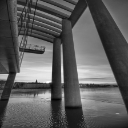

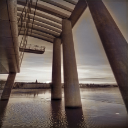

In [53]:
Testmodel(images[5])

(128, 128, 1)


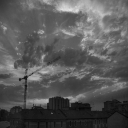

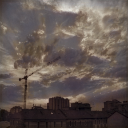

In [56]:
Testmodel(images[20])

(128, 128, 1)


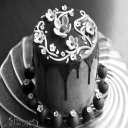

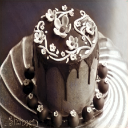

In [57]:
Testmodel(images[2])

(128, 128, 1)


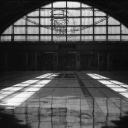

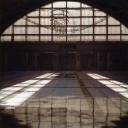

In [58]:
Testmodel(images[150])

(128, 128, 1)


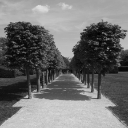

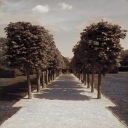

In [60]:
Testmodel(images[1950])

(128, 128, 1)


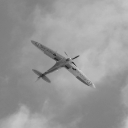

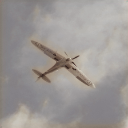

In [66]:
Testmodel(images[1659])